1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

In [31]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

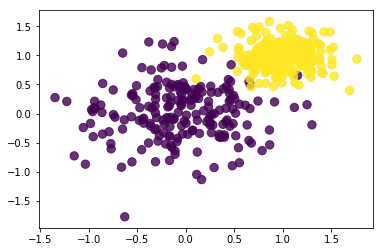

In [32]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

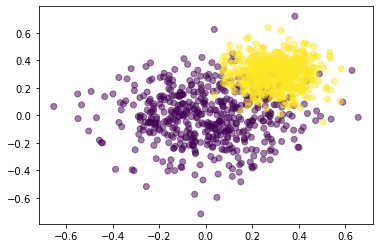

In [33]:
#1-Solution
import scipy.stats as stats
def generate_datasets(size, mean1=0, stand_dev1=0.2, mean2=0.3, stand_dev2=0.1):
    x1 = np.random.normal(mean1, stand_dev1, size)
    y1 = np.random.normal(mean1, stand_dev1, size)
    colors1 = np.full(size, 0)
    x2 = np.random.normal(mean2, stand_dev2, size)
    y2 = np.random.normal(mean2, stand_dev2, size)
    colors2 = np.full(size, 1)
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    colors = np.concatenate([colors1, colors2])
    return x, y, colors
x, y, colors = generate_datasets(500)
plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

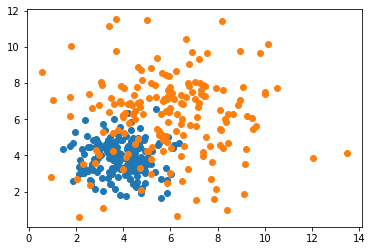

In [34]:
means = [4, 6]
stds  = [1.0, 2.2]
n=180
for i in range(len(means)):
    x = np.random.normal(means[i], stds[i], n)
    y = np.random.normal(means[i], stds[i], n)
    plt.scatter(x,y)

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [35]:
#2-Solution
#load by git bash
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

C:\Users\Marian\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


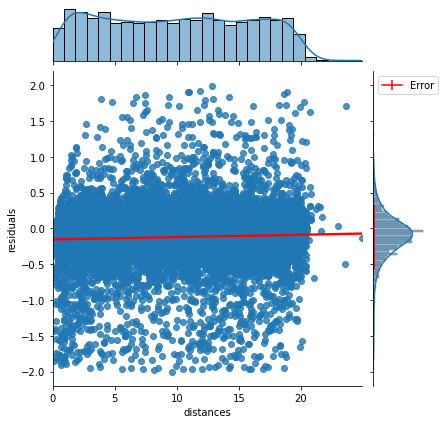

In [36]:

data = np.load('residuals_261.pkl',allow_pickle=True).item()
ds = pd.DataFrame(data)
ds = ds[ abs(ds['residuals'])<2 ]
lr = stats.linregress(ds['distances'], ds['residuals'])
sns.jointplot(ds['distances'], ds['residuals'], kind='reg',
             line_kws={'color':'red', 'label':'Lin.reg.'})
step = 15
x = np.linspace(0,20,step)
y = np.zeros(x.size)
arry = np.zeros(x.size)
c = 0
_e = x[0]
for e in x[1:]:
    b = ds[ ds['distances']>=_e ]
    b =  b[  b['distances']<e ]
    bVal = b['residuals']
    y[c] = bVal.mean()
    arry[c] = bVal.std()
    prevEl = e
    c += 1
plt.errorbar(x, y, yerr=arry, color='red', label='Error')
plt.legend();


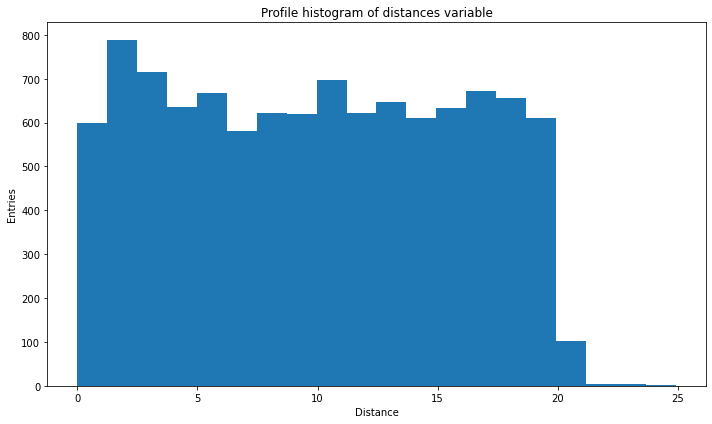

In [37]:
df = pd.DataFrame(data, columns=['residuals', 'distances'])
df_clean = df[abs(df['residuals']) < 2]
fig, ax = plt.subplots(figsize=(10, 6))
h, bins, _ = plt.hist(df_clean['distances'], bins=20)
ax.set_title('Profile histogram of distances variable')
ax.set_xlabel('Distance')
ax.set_ylabel('Entries')
fig.tight_layout()

x:  [ 0.6225  1.8675  3.1125  4.3575  5.6025  6.8475  8.0925  9.3375 10.5825
 11.8275 13.0725 14.3175 15.5625 16.8075 18.0525 19.2975 20.5425 21.7875
 23.0325 24.2775] 

y:  [-0.20298651 -0.16346985 -0.16058613 -0.13457787 -0.13448661 -0.09600764
 -0.09284342 -0.08822673 -0.0591651  -0.08039035 -0.11016332 -0.14977026
 -0.13796675 -0.15048569 -0.13854145 -0.07072831  0.05114286  0.20133333
  0.41285714 -0.12857143] 

err_y:  [0.46906745 0.42093315 0.40510863 0.4152323  0.41254988 0.47127579
 0.41610324 0.41383771 0.46252125 0.46764395 0.49306768 0.44858705
 0.47054736 0.4176323  0.41132145 0.38352696 0.49544021 0.14407945
 1.15402844        nan]


<ErrorbarContainer object of 3 artists>

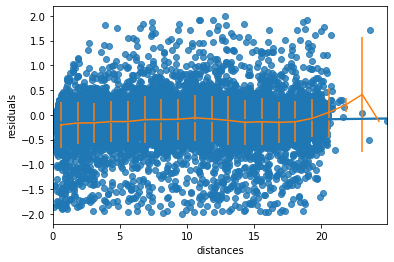

In [38]:
def compute_stats():
    x = []
    y = []
    err_y = []
    for index in range(len(bins)-1):
        left = bins[index]
        right = bins[index+1]
        center = (right - left) / 2 + left
        mean = df_clean[(df_clean['distances'] >= left) & (df_clean['distances'] <= right)]['residuals'].mean()
        std = df_clean[(df_clean['distances'] >= left) & (df_clean['distances'] <= right)]['residuals'].std()
        x.append(center)
        y.append(mean)
        err_y.append(std)
    x = np.array(x)
    y = np.array(y)
    err_y = np.array(err_y)
    return x, y, err_y
x, y, err_y = compute_stats()
print('x: ', x, '\n')
print('y: ', y, '\n')
print('err_y: ', err_y)
ax = sns.regplot(x='distances', y='residuals', data=df_clean)
ax.errorbar(x, y, yerr=err_y)

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


<ipython-input-39-2f619e268701>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


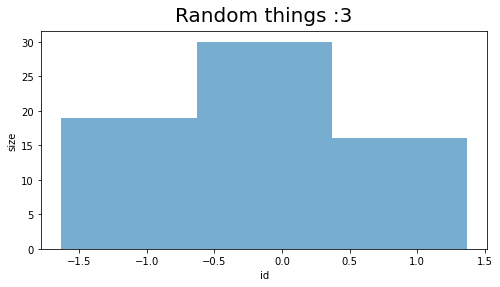

In [39]:
#3-Solution
N = 70
x = np.random.normal(0,1, N)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))
freq, bins,_  = ax.hist(x, bins=np.arange(x.min(), x.max()), alpha=0.6)
ax.set_title("Random things :3", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("id")
ax.set_ylabel("size")
fig.show()

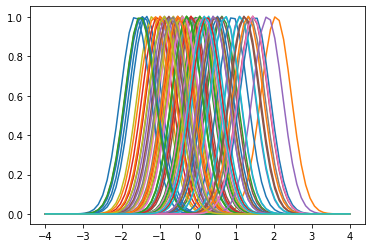

Normalized integral: 69.99999933393384
Histogram: 65.0


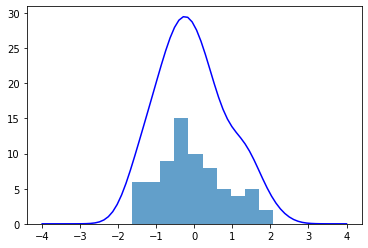

In [40]:
norms = []
for i in x:
    d = np.linspace(-4, 4, N)
    g = stats.norm.pdf(d, i, 1.06*x.std()*x.size**(-(1/5)))
    norms.append(g)
    plt.plot(d, g, '-')
plt.show()
norms = np.array(norms)
s = np.sum(norms, axis=0)
step_size = bins[1] - bins[0]
print("Normalized integral:", integrate.trapz(s*step_size, d))
print("Histogram:", np.sum(step_size*freq))
plt.hist(x, alpha = 0.7);
plt.plot(d, s*step_size, '-b');

<ipython-input-42-422ed4bbfde7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[0].get_xticks())


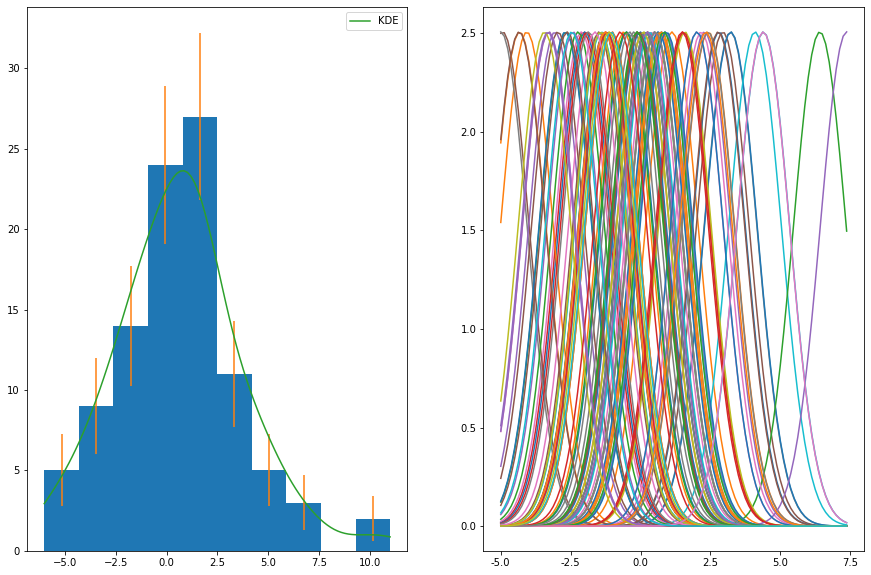

In [42]:
#Another Solution for question 3
import math
N=100
mu=0
sigma=3
x = np.random.normal(0,3,N)
fig, ax = plt.subplots(1,2,figsize=(15,10))
n, bins, patches = ax[0].hist(x)
ax[0].set_ylabel="Counts"
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax[0].errorbar(bin_centers,n,yerr = n**0.5,linestyle='None')

g_std=1.06*np.std(x)*len(x)**(-1/5)
g_total=0
for m in x:
    g = stats.norm(m, g_std).pdf(np.linspace(np.min(x),np.max(x),N))*2*math.pi*g_std
    ax[1].plot(g)
    g_total += g
ax[1].set_xticklabels(ax[0].get_xticks())
norm_const = integrate.trapz(y=g_total,x=np.linspace(np.min(x),np.max(x),N))
area_of_hist=sum(n*(bins[1:] - bins[:-1]))
gaussianKDE = area_of_hist*g_total/norm_const
ax[0].plot(np.linspace(np.min(x),np.max(x),N),gaussianKDE, label="KDE")

ax[0].legend()